In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from bertopic import BERTopic
import nltk
import nltk.corpus
from gensim.models import Word2Vec
import os
from wordcloud import WordCloud
import collections
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

In [2]:
# get words from the text corpus

from nltk.corpus import PlaintextCorpusReader
wordlists = PlaintextCorpusReader('da/processed', '.*')

da_words = []

for file in wordlists.fileids():
        da_words.append(wordlists.words(file))

In [3]:
# get the rosetta data

data_raw = pd.read_excel("rosetta_data_inputs_2023.xls")

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [4]:
# Get main columns and filter rows without headings
data = data_raw[["Overskrift", "Beskrivelse"]]
data = data[data["Overskrift"].notna()]

In [5]:
# remove danish words, stopwords, and extra words and prep data for use

filter_words = ['able','also','and','amount','around','away','better','carry','catch',
                'certain','close','correct','contact','could','create','different',
                'dont','easier','easy','etc','fast','find','friendly','generate',
                'get','go','good','help','idea','instead','like','nice','made','make',
                'may','maybe','might','must','need','new','non','old','one','picture',
                'possible','put','random','reduce','revenue','secondary','send',
                'small','something','specific','strong','stuff','take','things',
                'use','used','using','without','word','would']

def filter_danish(text):
       return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.casefold() not in da_words and 
                       w.casefold() not in filter_words and w.isalpha())

# combine heading and description
title_strings = data['Overskrift'].astype('str')
description_strings = data['Beskrivelse'].astype('str')
docs = title_strings + " \n\n" + description_strings

docs.apply(filter_danish)

1       Combi material design a combination of materia...
2       Sterilization with UV light UVC light can be t...
3       seperation by oscillation Protein powder is in...
4       high pressure expose the product to high enoug...
5       Filtration push the product through a membrane...
                              ...                        
5487    Weather resistance inspired by arctic animals ...
5488    Multiple options for power generation To provi...
5489    Adaptable To increase the maneuverability of t...
5490    Weather balloon for communication relay Satell...
5491    Adaptable sensor image frequency resolution Lo...
Length: 5339, dtype: object

### BERT Topic Model

In [7]:
## BERT Topic Model

from sklearn.feature_extraction.text import CountVectorizer

# Remove stopwords after documents are assigned to topics
# Allows the transformer model to get the full context of the 
# data, while removing stopwords that are noise in the topics
vectorizer_model = CountVectorizer(stop_words="english")

# Define and train the model
topic_model = BERTopic(nr_topics=20, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info() 

KeyboardInterrupt: 

### K-Means Clustering

In [6]:
# tokenize filtered text, removing stopwords

def tokenize_text(text, tokenizer):
    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stop_words]  # Remove stopwords
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

tokens = docs.map(lambda x: tokenize_text(x, nltk.word_tokenize))

In [64]:
# get token frequencies across the entire dataset

counter = collections.Counter(tokens.explode().dropna().to_numpy())
freqs = dict(counter)

In [7]:
# setup word2vec embeddings
model = Word2Vec(sentences=tokens, vector_size=100, workers=1)

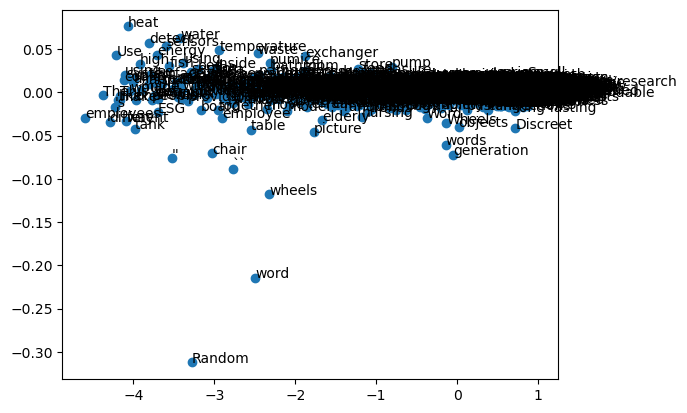

In [8]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
X = model.wv.vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.key_to_index)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [43]:
from sklearn import cluster
from sklearn import metrics
NUM_CLUSTERS = 20
X = model.wv.vectors
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[ 3  9  9 ... 12 12 12]
Centroids data
[[-0.01845689  0.06912409  0.05224663 ... -0.18412398  0.06104542
   0.02839405]
 [-0.05424862  0.19328615  0.14619398 ... -0.5185782   0.17014481
   0.08079381]
 [-0.00659725  0.02437729  0.01828757 ... -0.06369576  0.02113737
   0.01018248]
 ...
 [-0.02904809  0.10471119  0.07853772 ... -0.27908385  0.09222901
   0.04342263]
 [-0.03699971  0.13477497  0.1019702  ... -0.3591105   0.11718211
   0.05642201]
 [-0.08477226  0.31688794  0.23701386 ... -0.84665096  0.27965042
   0.12822327]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-20.547637939453125
Silhouette_score: 
0.292602


#### Create Word Clouds of K-Means Clusters

In [48]:
# get data subsets for each cluster

cluster_zero_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 0]
cluster_one_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 1]
cluster_two_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 2]
cluster_three_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 3]
cluster_four_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 4]
cluster_five_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 5]
cluster_six_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 6]
cluster_seven_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 7]
cluster_eight_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 8]
cluster_nine_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 9]
cluster_ten_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 10]

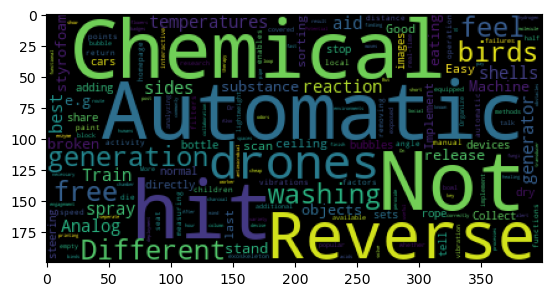

In [76]:
# get frequencies of each cluster's words and create word_clouds

cluster_zero_freqs = {x:freqs[x] for x in cluster_zero_words}
wc_zero = WordCloud().fit_words(cluster_zero_freqs)
plt.imshow(wc_zero)

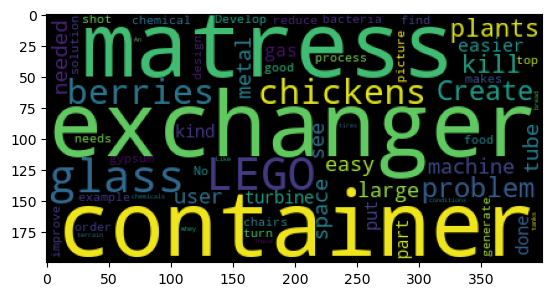

In [77]:
cluster_one_freqs = {x:freqs[x] for x in cluster_one_words}
wc_one = WordCloud().fit_words(cluster_one_freqs)
plt.imshow(wc_one)